## LangGraph Basic Components

### State

In [1]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    today_signal: bool = None
    current_answer: str = None

### Nodes

In [2]:
def node_1(state):
    print("---Node 1---")
    state.current_answer = "I am "
    return state

def node_2(state):
    print("---Node 2---")
    state.current_answer += "happy!"
    return state

def node_3(state):
    print("---Node 3---")
    state.current_answer += "sad!"
    return state

### Edges

In [3]:
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    # Often, we will use state to decide on the next node to visit
    if state.today_signal == True:
        return "node_2"
    
    else:
        return "node_3"

### Graph Construction

In [4]:
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

### Show Graph

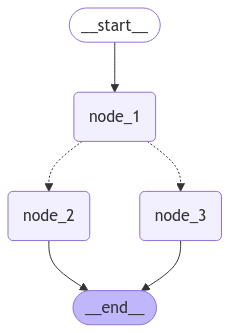

In [5]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation (Running the Graph)

In [6]:
user_input = OverallState(today_signal=False)
graph.invoke(user_input)

---Node 1---
---Node 3---


{'today_signal': False, 'current_answer': 'I am sad!'}

In [9]:
user_input = OverallState(today_signal=True)
graph.invoke(user_input)

---Node 1---
---Node 2---


{'today_signal': True, 'current_answer': 'I am happy!'}

### LangGraph Simple Math Example

In [7]:
from typing import TypedDict

class MyState(TypedDict):
    number1: float
    number2: float
    result: float

In [10]:
def node_init(state: "MyState") -> "MyState":
    """
    A simple initialization node. 
    Maybe set up initial result to 0 or just print something for debugging.
    """
    print("---Node Init---")
    state["result"] = 0
    return state

def node_add(state: "MyState") -> "MyState":
    """
    This node adds number1 and number2, storing the result in state['result'].
    """
    print("---Node Add---")
    total = state["number1"] + state["number2"]
    state["result"] = total
    return state

def node_multiply(state: "MyState") -> "MyState":
    """
    This node multiplies number1 and number2, storing the result in state['result'].
    """
    print("---Node Multiply---")
    product = state["number1"] * state["number2"]
    state["result"] = product
    return state

def node_divide_by_two(state: "MyState") -> "MyState":
    """
    This node divides number1 by number2, storing the result in state['result'].
    """
    print("---Node Divide---")
    state["result"] = state["result"] / 2
    return state


In [11]:
# edges.py
from typing import Literal

def decide_operation(state: "MyState") -> Literal["node_add", "node_multiply"]:
    if (state["number1"] + state["number2"]) > 10:
        return "node_multiply"
    else:
        return "node_add"


In [15]:
# graph_construction.py
from langgraph.graph import StateGraph, START, END

# 1) Build the graph with StateGraph, indicating MyState as the type for state
builder = StateGraph(MyState)

# 2) Add nodes
builder.add_node("node_init", node_init)
builder.add_node("node_add", node_add)
builder.add_node("node_multiply", node_multiply)
builder.add_node("node_divide_by_two", node_divide_by_two)

# 3) Add edges
#    START -> node_init
builder.add_edge(START, "node_init")

#    node_init -> either node_add or node_multiply based on decide_operation
builder.add_conditional_edges("node_init", decide_operation)

#    node_add -> node_divide_by_two -> END
builder.add_edge("node_add", "node_divide_by_two")
builder.add_edge("node_divide_by_two", END)

#    node_multiply -> END
builder.add_edge("node_multiply", END)

# 4) Compile the graph
graph = builder.compile()


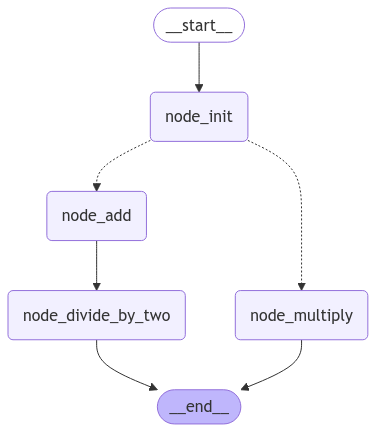

In [16]:
# 5) Visualize (optional)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
#This dictionary must match MyState's keys and expected types.
user_input = {
    "number1": 2.0,
    "number2": 7.0,
}

final_state = graph.invoke(user_input)
print("Final State:", final_state)

---Node Init---
---Node Add---
---Node Divide---
Final State: {'number1': 2.0, 'number2': 7.0, 'result': 4.5}
